In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

## Read the dataset and perform necessary data tidying

In [2]:
# Read the data
df = pd.read_excel("soil_data.xlsx")

# Convert SOC from g/kg to %
df['SOC'] = df['SOC'] / 10

# Select features
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP']

# Remove rows that contain NaN values in the selected feature columns
df = df.dropna(subset=features)

# Select only the feature variables needed for correlation calculation
df_features = df[features]

df.head()


,no,year,date,treatmentnumber,treatment,plot,depthnumber,depth,SOC,sand,...,clay,BD,FC,FC_33,PWP,Ka,EC,SAR,WR,pH
3,4,2021,2021-03-27,0,rainfed,2,1,0-20,1.912,58.430458,...,10.878011,1.148851,0.3126,0.2677,0.1680,28.257534,0.131567,0.267706,7.25,7.61
4,5,2021,2021-03-27,0,rainfed,2,2,20-40,1.897,58.326958,...,11.469644,1.388839,0.3086,0.2763,0.1954,7.093154,0.126533,0.139694,20.25,7.58
5,6,2021,2021-03-27,0,rainfed,2,3,40-60,1.699,57.414452,...,10.646388,1.438689,0.3086,0.2693,0.1580,1.123574,0.120433,0.294239,24.75,7.57
9,10,2021,2021-03-27,0,rainfed,4,1,0-20,1.655,59.471977,...,10.421492,1.348851,0.2981,0.2302,0.1640,5.548042,0.124367,0.142143,19.25,7.61
10,11,2021,2021-03-27,0,rainfed,4,2,20-40,1.631,59.312145,...,10.363888,1.588839,0.3496,0.2945,0.1622,2.006630,0.124867,0.263550,17.50,7.64


## Calculate the Pearson correlation and p-value, marking significant differences with *

In [3]:
# Select feature variables
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP']  
# If calculating for the 0-60 cm depth, include 'depthnumber' and 'treatmentnumber'

# Calculate the Pearson correlation matrix and the p-value matrix
correlation_matrix = pd.DataFrame(index=features, columns=features)
p_value_matrix = pd.DataFrame(index=features, columns=features)

for feature1 in features:
    for feature2 in features:
        if feature1 == feature2:
            correlation_matrix.loc[feature1, feature2] = 1.0
            p_value_matrix.loc[feature1, feature2] = 0.0
        else:
            corr, p_value = pearsonr(df[feature1], df[feature2])
            correlation_matrix.loc[feature1, feature2] = corr
            p_value_matrix.loc[feature1, feature2] = p_value

# Print the correlation matrix
print("Pearson correlation coefficients:")
print(correlation_matrix)

# Print the p-value matrix
print("\nP-values for the Pearson correlation coefficients:")
print(p_value_matrix)

# Mark pairs of features with significant correlations (p-value < 0.05)
print("\nSignificant correlations (p-value < 0.05):")
significant_correlation_matrix = correlation_matrix.copy()

for feature1 in features:
    for feature2 in features:
        if feature1 != feature2 and p_value_matrix.loc[feature1, feature2] < 0.05:
            significant_correlation_matrix.loc[feature1, feature2] = f"{correlation_matrix.loc[feature1, feature2]:.3f}*"

print(significant_correlation_matrix)

# Save the significant correlation matrix to a CSV file
significant_correlation_matrix.to_csv('significant_correlation_matrix.csv', index=False)


Pearson correlation coefficients:
            SOC      sand      silt      clay        BD        FC     FC_33  \
SOC         1.0 -0.311044  0.189334  0.563066 -0.192017  0.321034  0.346155   
sand  -0.311044       1.0 -0.972643 -0.715055 -0.173645 -0.673239 -0.687953   
silt   0.189334 -0.972643       1.0  0.533096  0.151857  0.622956  0.627195   
clay   0.563066 -0.715055  0.533096       1.0  0.175434  0.577293  0.618123   
BD    -0.192017 -0.173645  0.151857  0.175434       1.0  0.390704  0.369912   
FC     0.321034 -0.673239  0.622956  0.577293  0.390704       1.0  0.967851   
FC_33  0.346155 -0.687953  0.627195  0.618123  0.369912  0.967851       1.0   
PWP    0.465519 -0.360476  0.271607  0.495512   0.11278  0.560693  0.545896   

            PWP  
SOC    0.465519  
sand  -0.360476  
silt   0.271607  
clay   0.495512  
BD      0.11278  
FC     0.560693  
FC_33  0.545896  
PWP         1.0  

P-values for the Pearson correlation coefficients:
            SOC      sand      silt     

## Test different Pedo-tansfer models on FC, PWP, and together calculation

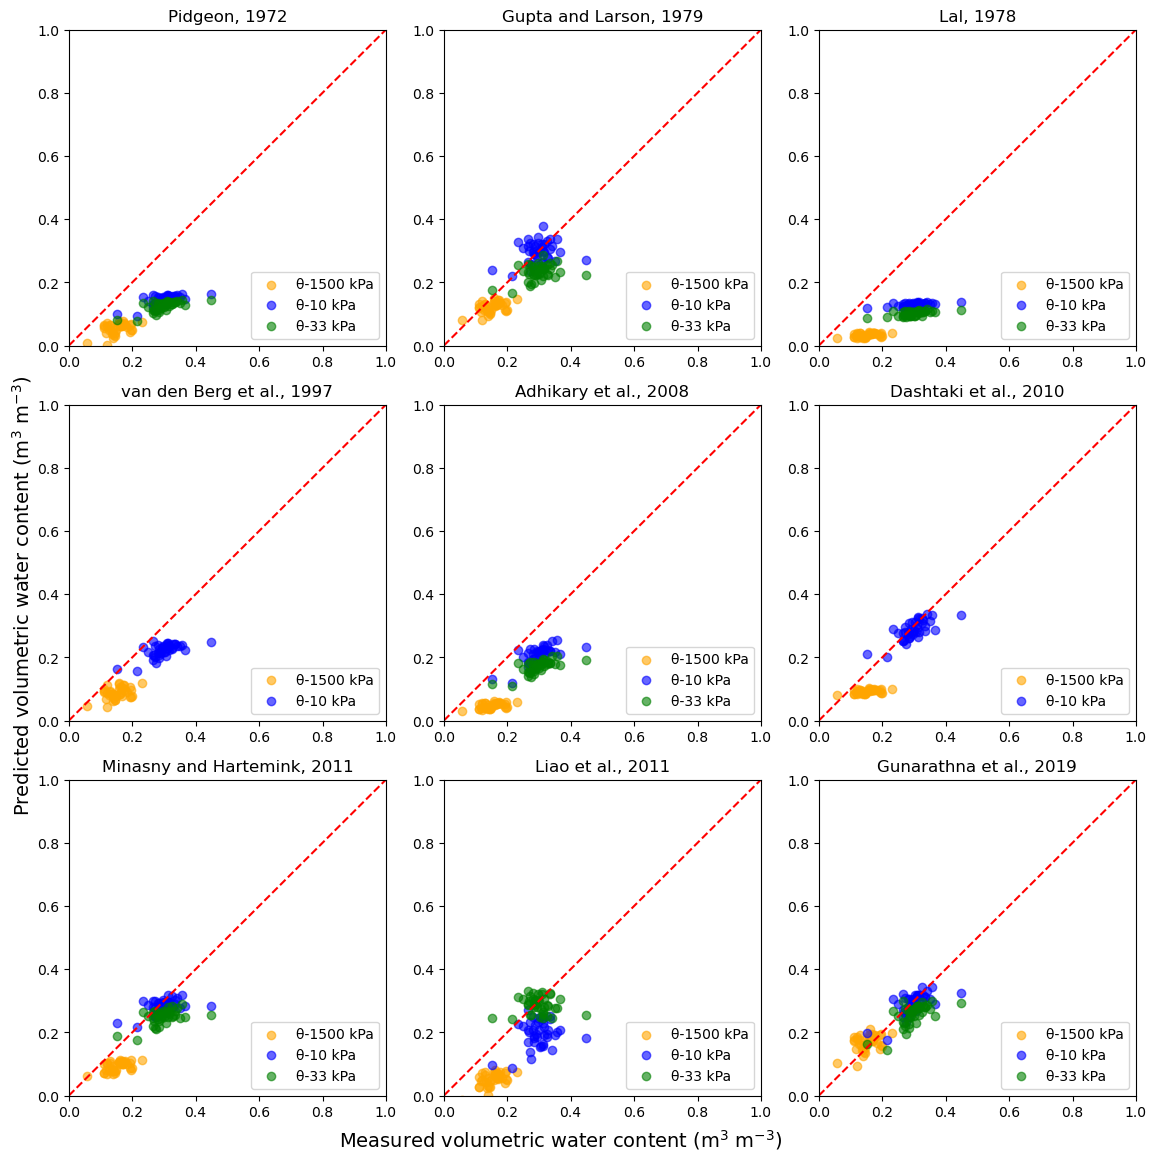

In [4]:
# Calculate FC_10 predictions for each model
df['fc10_Pidgeon1972'] = (100 * (0.0738 + 0.0016 * df['silt'] + 0.003 * df['clay'] + 0.0075 * df['SOC']) - 2.54) / 91
df['fc10_Gupta1979'] = 0.005018*df['sand'] + 0.008548*df['silt'] + 0.008833*df['clay'] + 0.00288051 *df['SOC'] - 0.2423*df['BD']
df['fc10_Lal1978'] = 0.102 + 0.003 * df['clay']
df['fc10_vandenberg1997'] = 0.1088 + 0.00347 * df['clay'] + 0.00211 * df['silt'] + 0.01756 * df['SOC']
df['fc10_Adhikary2008'] = 0.6250 - 0.0058 * df['sand'] - 0.0021 * df['silt'] 
df['fc10_Dashtaki2010'] = 0.343 - 0.0038 * df['sand'] + 0.124 * df['BD']
df['fc10_Minasny2011'] = 0.599 - 0.0878 * df['BD'] - 0.0031 * df['sand'] 

df['fc10_Liao2011'] = (
    -2.44344 + 
    2.128 * df['BD'] + 
    0.275 * np.log(df['sand']) + 
    0.068 * np.log(df['SOC']) + 
    0.00013 * df['silt']**2 - 
    0.808 * df['BD']**2 - 
    0.00003364  * df['sand'] * df['SOC'] + 
    0.00008 * (df['BD']**2) * (df['clay']**2)
)

df['fc10_Gunarathna2019'] = 0.3951 - 0.0029*df['sand'] + 0.0023*df['silt'] + 0.0052*df['SOC']**2


# Calculate FC_33 predictions for each model
df['fc33_Pidgeon1972'] = (100 * (0.0738 + 0.0016 * df['silt'] + 0.003 * df['clay'] + 0.0075 * df['SOC']) - 3.77) / 95
df['fc33_Gupta1979'] = 0.003075*df['sand'] + 0.005886*df['silt'] + 0.008039*df['clay'] + 0.00128074 *df['SOC'] - 0.1434*df['BD']
df['fc33_Lal1978'] = 0.065 + 0.004 * df['clay']
df['fc33_Adhikary2008'] = 0.5637 - 0.0051 * df['sand'] - 0.0027 * df['silt'] 

df['fc33_Minasny2011'] = 0.565 - 0.0749 * df['BD'] - 0.0034 * df['sand'] 

df['fc33_Liao2011'] = (
    -1.88394 + 
    3.158 * df['BD'] +  
    0.042 * np.log(df['SOC']) - 
    1.139 * df['BD']**2 - 
    0.000058 * df['sand'] * df['SOC'] + 
    0.000058 * df['silt'] * df['SOC'] 
)

df['fc33_Gunarathna2019'] = 0.3686 - 0.0029*df['sand'] + 0.0018*df['silt'] + 0.0082 *df['SOC']**2



# Calculate PWP predictions for each model
df['pwp_Pidgeon1972'] = -0.0419 + 0.0019 * df['silt'] + 0.0039 * df['clay'] + 0.0045 * df['SOC']

df['pwp_Gupta1979'] = -0.000059 *df['sand'] + 0.001142 *df['silt'] + 0.005766*df['clay'] + 0.00129234 *df['SOC'] + 0.02671*df['BD']

df['pwp_Lal1978'] = 0.006 + 0.003 * df['clay']

df['pwp_vandenberg1997'] = 0.00334 * df['clay'] * df['BD'] + 0.00104 * df['silt'] * df['BD']

df['pwp_Adhikary2008'] = 0.0071 + 0.0044  * df['clay']

df['pwp_Dashtaki2010'] = 0.062 + 0.0033 * df['clay']

df['pwp_Minasny2011'] = 0.0795 + 0.0086 * df['SOC'] + 0.004 * df['clay'] - 0.00004 * (df['clay'] - 37.7)**2

df['pwp_Liao2011'] = (
    0.159075 + 
    0.025 * np.log(df['SOC']) -
    0.00012 * df['silt']**2 -
    0.092 * df['BD']**2 - 
    0.000085 * df['sand'] * df['silt'] + 
    0.0000174 * df['silt'] * df['SOC'] +
    0.008 * df['silt'] * df['BD'] + 
    0.00069606 * df['BD'] * df['SOC']
)

df['pwp_Gunarathna2019'] = 0.3278 - 0.0028 *df['sand']  + 0.0082 * df['SOC']**2


# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Define models and their titles
models = [
    ('fc10_Pidgeon1972', 'fc33_Pidgeon1972', 'pwp_Pidgeon1972', 'Pidgeon, 1972'),
    ('fc10_Gupta1979','fc33_Gupta1979','pwp_Gupta1979', 'Gupta and Larson, 1979'),
    ('fc10_Lal1978', 'fc33_Lal1978', 'pwp_Lal1978', 'Lal, 1978'),
    ('fc10_vandenberg1997', None, 'pwp_vandenberg1997', 'van den Berg et al., 1997'),
    ('fc10_Adhikary2008', 'fc33_Adhikary2008', 'pwp_Adhikary2008', 'Adhikary et al., 2008'),
    ('fc10_Dashtaki2010', None, 'pwp_Dashtaki2010', 'Dashtaki et al., 2010'),
    ('fc10_Minasny2011', 'fc33_Minasny2011','pwp_Minasny2011', 'Minasny and Hartemink, 2011'),
    ('fc10_Liao2011', 'fc33_Liao2011', 'pwp_Liao2011', 'Liao et al., 2011'),
    ('fc10_Gunarathna2019','fc33_Gunarathna2019','pwp_Gunarathna2019', 'Gunarathna et al., 2019')
]

# Define color
colors = {
    'FC10': 'blue',
    'FC33': 'green',  
    'PWP': 'orange' 
}

# Plot each model
for ax, (fc10_model, fc33_model, pwp_model, title) in zip(axs.flatten(), models):
    # Plot PWP scatter (orange)
    ax.scatter(df['PWP'], df[pwp_model], color=colors['PWP'], alpha=0.6, label='θ-1500 kPa')
    
    # Plot FC10 scatter (blue)
    ax.scatter(df['FC'], df[fc10_model], color=colors['FC10'], alpha=0.6, label='θ-10 kPa')
    
    # Plot FC33 scatter (green) if applicable
    if fc33_model:
        ax.scatter(df['FC'], df[fc33_model], color=colors['FC33'], alpha=0.6, label='θ-33 kPa')
    
    # Plot ideal diagonal line
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.legend(loc='lower right')
    
    # Remove individual subplot x and y labels
    ax.set_xlabel('')
    ax.set_ylabel('')

# Add overall x and y labels
fig.text(0.5, 0.04, 'Measured volumetric water content (m$^3$ m$^{-3}$) ', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted volumetric water content (m$^3$ m$^{-3}$) ', va='center', rotation='vertical', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave space for x and y labels
plt.savefig("predicted_vs_measured_water_content_colored.png")  # Save the plot
plt.show()


## Estimate the model and export the results

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the Applicability Index (AI)
def applicability_index(pred, actual):
    return (np.sum(~np.isnan(pred)) / len(actual)) * 100

# Calculate the Mean Error (ME)
def mean_error(pred, actual):
    return np.nanmean(pred - actual)

# Calculate the Standard Deviation of Error (SDE)
def std_error(pred, actual):
    return np.nanstd(pred - actual)

# Calculate the Root Mean Square Error (RMSE)
def rmse(pred, actual):
    return np.sqrt(mean_squared_error(actual, pred))

# Initialize the results list
results = []

# Define the models and their titles
models = [
    ('fc10_Pidgeon1972', 'fc33_Pidgeon1972', 'pwp_Pidgeon1972', 'Pidgeon, 1972'),
    ('fc10_Gupta1979','fc33_Gupta1979','pwp_Gupta1979', 'Gupta and Larson, 1979'),
    ('fc10_Lal1978', 'fc33_Lal1978', 'pwp_Lal1978', 'Lal, 1978'),
    ('fc10_vandenberg1997', None, 'pwp_vandenberg1997', 'van den Berg et al., 1997'),
    ('fc10_Adhikary2008', 'fc33_Adhikary2008', 'pwp_Adhikary2008', 'Adhikary et al., 2008'),
    ('fc10_Dashtaki2010', None, 'pwp_Dashtaki2010', 'Dashtaki et al., 2010'),
    ('fc10_Minasny2011', 'fc33_Minasny2011','pwp_Minasny2011', 'Minasny and Hartemink, 2011'),
    ('fc10_Liao2011', 'fc33_Liao2011', 'pwp_Liao2011', 'Liao et al., 2011'),
    ('fc10_Gunarathna2019','fc33_Gunarathna2019','pwp_Gunarathna2019', 'Gunarathna et al., 2019')
]

# Calculate metrics for each model and store them in the results list
for fc10_model, fc33_model, pwp_model, title in models:
    # Calculate PWP-related metrics
    if pwp_model:
        pred_pwp = df[pwp_model]
        actual_pwp = df['PWP']
        ai_pwp = applicability_index(pred_pwp, actual_pwp)
        me_pwp = mean_error(pred_pwp, actual_pwp)
        sde_pwp = std_error(pred_pwp, actual_pwp)
        rmse_pwp = rmse(pred_pwp, actual_pwp)
        results.append([title, 'PWP', ai_pwp, me_pwp, sde_pwp, rmse_pwp])
    
    # Calculate FC10-related metrics
    if fc10_model:
        pred_fc10 = df[fc10_model]
        actual_fc = df['FC']
        ai_fc10 = applicability_index(pred_fc10, actual_fc)
        me_fc10 = mean_error(pred_fc10, actual_fc)
        sde_fc10 = std_error(pred_fc10, actual_fc)
        rmse_fc10 = rmse(pred_fc10, actual_fc)
        results.append([title, 'FC10', ai_fc10, me_fc10, sde_fc10, rmse_fc10])

    # Calculate FC33-related metrics
    if fc33_model:
        pred_fc33 = df[fc33_model]
        ai_fc33 = applicability_index(pred_fc33, actual_fc)
        me_fc33 = mean_error(pred_fc33, actual_fc)
        sde_fc33 = std_error(pred_fc33, actual_fc)
        rmse_fc33 = rmse(pred_fc33, actual_fc)
        results.append([title, 'FC33', ai_fc33, me_fc33, sde_fc33, rmse_fc33])

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Type', 'Applicability Index (%)', 'Mean Error (m3/m3)', 'Standard Deviation of Error (m3/m3)', 'RMSE (m3/m3)'])
results_df.head()

# Save the results to a CSV file
results_df.to_csv('model_performance.csv', index=False)

print("Results saved to 'model_performance.csv'")

Results saved to 'model_performance.csv'


## Take into consideration TWW and calculate the VIF to check for collinearity, then build the pedotransfer function based on the database


In [6]:
# Read the data
df = pd.read_excel("soil_data.xlsx")

# Convert SOC from g/kg to %
df['SOC'] = df['SOC'] / 10

# Rename columns for soil water content at different kPa levels
df['θ-10 kPa'] = df['FC']
df['θ-33 kPa'] = df['FC_33']
df['θ-1500 kPa'] = df['PWP']

# Select feature variables
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'Ka', 'EC', 'SAR', 'WR', 'pH', 'FC', 'FC_33', 'PWP']

# Remove rows with NaN values in the selected feature columns
df = df.dropna(subset=features)

# Select only the feature variables for calculating correlation
df_features = df[features]

# Calculate descriptive statistics
descriptive_stats = df_features.describe().T

# Select the required statistics
descriptive_stats = descriptive_stats[['min', 'max', 'mean', 'std']]

# Output the result
print(descriptive_stats)

# Save the result to a CSV file
descriptive_stats.to_csv('descriptive_statistics.csv', index=True)


             min         max       mean        std
SOC     0.228000    2.458000   1.113976   0.549765
sand   49.611824   83.618767  61.244285   6.927561
silt   10.052122   42.206814  29.507466   5.724024
clay    5.592007   12.341063   9.248248   1.902133
BD      1.148851    1.638689   1.430221   0.103176
Ka      0.000000   67.947421   6.504163  12.317966
EC      0.088067    0.245000   0.153276   0.042092
SAR     0.139694    2.333199   0.756635   0.524683
WR      6.250000  103.500000  28.786585  21.178967
pH      6.890000    7.880000   7.465610   0.260327
FC      0.151800    0.449700   0.298107   0.045873
FC_33   0.066300    0.385900   0.241956   0.051788
PWP     0.055700    0.230800   0.152167   0.032339


In [7]:
# Select feature variables
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'Ka', 'EC', 'SAR', 'WR', 'pH', 'θ-10 kPa', 'θ-33 kPa', 'θ-1500 kPa']

# Select only the feature variables needed for correlation calculation
df_features = df[features]

# Add an intercept term for VIF calculation
df_features_with_intercept = df_features.assign(Intercept=1)

# Define the VIF calculation function
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# Calculate the initial VIF
vif_data = calculate_vif(df_features_with_intercept)
print("Initial VIF data:")
print(vif_data)

# Save the VIF results
vif_data.to_csv('vif_data.csv', index=False)


Initial VIF data:
       Feature           VIF
0          SOC  2.746626e+00
1         sand  1.358552e+13
2         silt  9.276209e+12
3         clay  1.024826e+12
4           BD  1.836089e+00
5           Ka  1.436437e+00
6           EC  1.453597e+00
7          SAR  1.794028e+00
8           WR  1.643487e+00
9           pH  2.346831e+00
10    θ-10 kPa  2.049582e+01
11    θ-33 kPa  2.061096e+01
12  θ-1500 kPa  2.156340e+00
13   Intercept  3.002400e+15


In [8]:
# Define the VIF calculation function
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# Calculate the initial VIF
features_df = df[features]
features_df = features_df.assign(Intercept=1)
vif_data = calculate_vif(features_df)

# Iteratively remove the feature with the highest VIF until all VIF values are below 10
while vif_data['VIF'].max() > 10:
    # Get the feature with the highest VIF
    max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
    print(f"Removing {max_vif_feature} with VIF = {vif_data['VIF'].max()}")
    
    # Drop the feature with the highest VIF
    features_df = features_df.drop(columns=[max_vif_feature])
    
    # Recalculate VIF
    vif_data = calculate_vif(features_df)

# Print the final VIF data
vif_data['Tolerance'] = 1 / vif_data['VIF']
print("Final VIF data after removing high VIF features:")
print(vif_data)


Removing Intercept with VIF = 3002399751580330.5
Removing pH with VIF = 1920.2246759976808
Removing θ-10 kPa with VIF = 787.1701131630725
Removing BD with VIF = 345.16211964095857
Removing clay with VIF = 73.59908908757447
Removing θ-33 kPa with VIF = 60.01144928950607
Removing θ-1500 kPa with VIF = 32.805260457186094
Removing sand with VIF = 26.172717955960522
Removing silt with VIF = 15.61872177015179
Final VIF data after removing high VIF features:
  Feature       VIF  Tolerance
0     SOC  5.098682   0.196129
1      Ka  1.364020   0.733127
2      EC  9.816427   0.101870
3     SAR  3.122157   0.320291
4      WR  2.832823   0.353005


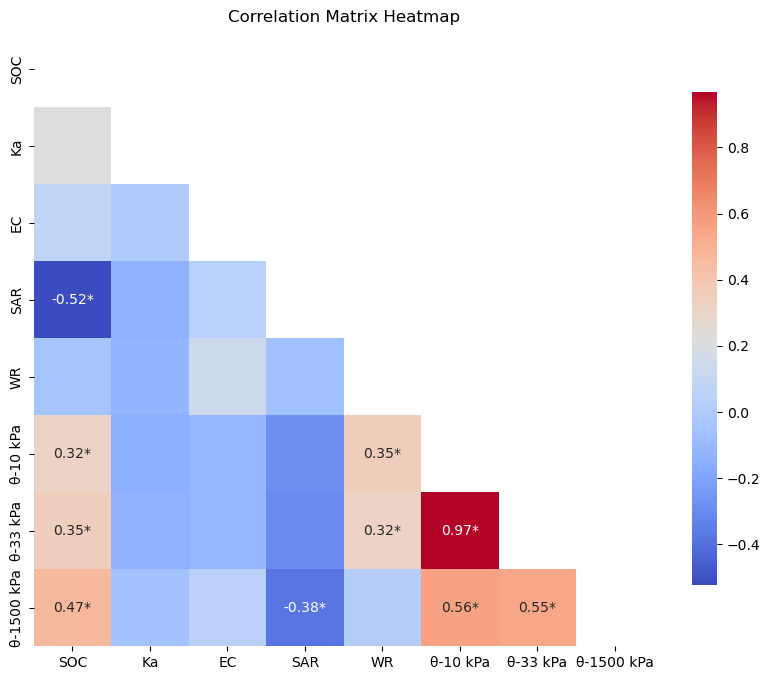

In [9]:
# Select feature variables
features = ['SOC', 'Ka', 'EC', 'SAR', 'WR', 'θ-10 kPa', 'θ-33 kPa', 'θ-1500 kPa']

# Remove rows with NaN values in the selected feature variables
df = df.dropna(subset=features)

# Select only the feature variables for correlation calculation
df_features = df[features]

# Calculate the correlation matrix
corr_matrix = df_features.corr()

# Calculate the p-value matrix
pval_matrix = pd.DataFrame(index=features, columns=features)
for row in features:
    for col in features:
        _, pval_matrix.loc[row, col] = pearsonr(df_features[row], df_features[col])

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create an annotation matrix to mark significance
annot = pd.DataFrame('', index=features, columns=features)
for row in features:
    for col in features:
        if pval_matrix.loc[row, col] < 0.05 and row != col:
            annot.loc[row, col] = str(corr_matrix.loc[row, col].round(2)) + '*'
        else:
            annot.loc[row, col] = ''  # Leave non-significant values empty

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=annot, fmt='', cmap='coolwarm', mask=mask, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.savefig('correlation_heatmap.png')  # Save the plot
plt.show()


In [10]:
# Prepare data for FC prediction
X_fc = df[['SOC', 'WR']]
y_fc = df['FC']
X_train_fc, X_test_fc, y_train_fc, y_test_fc = train_test_split(X_fc, y_fc, test_size=0.2, random_state=42)

# Model training for FC
model_fc = LinearRegression()
model_fc.fit(X_train_fc, y_train_fc)
y_pred_fc = model_fc.predict(X_test_fc)
mse_fc = mean_squared_error(y_test_fc, y_pred_fc)
r2_fc = r2_score(y_test_fc, y_pred_fc)
print(f"Mean Squared Error for FC: {mse_fc}")
print(f"R² for FC: {r2_fc}")

# Get the model's intercept and coefficients
intercept = model_fc.intercept_
coefficients = model_fc.coef_
features = X_fc.columns

# Build the formula string
formula = f"FC = {intercept:.4f} "
for coef, feature in zip(coefficients, features):
    formula += f"+ ({coef:.4f}) * {feature} "

# Print the formula
print("Regression Formula for FC:")
print(formula)


Mean Squared Error for FC: 0.0022805185684048246
R² for FC: 0.2648102529328935
Regression Formula for FC:
FC = 0.2563 + (0.0186) * SOC + (0.0008) * WR 


In [11]:
# Prepare data for FC_33 prediction
X_fc_33 = df[['SOC', 'WR']]
y_fc_33 = df['FC_33']
X_train_fc_33, X_test_fc_33, y_train_fc_33, y_test_fc_33 = train_test_split(X_fc_33, y_fc_33, test_size=0.2, random_state=42)

# Model training for FC_33
model_fc_33 = LinearRegression()
model_fc_33.fit(X_train_fc_33, y_train_fc_33)
y_pred_fc_33 = model_fc_33.predict(X_test_fc_33)
mse_fc_33 = mean_squared_error(y_test_fc_33, y_pred_fc_33)
r2_fc_33 = r2_score(y_test_fc_33, y_pred_fc_33)
print(f"Mean Squared Error for FC_33: {mse_fc_33}")
print(f"R² for FC_33: {r2_fc_33}")

# Get the model's intercept and coefficients
intercept = model_fc_33.intercept_
coefficients = model_fc_33.coef_
features = X_fc_33.columns

# Build the formula string
formula = f"FC_33 = {intercept:.4f} "
for coef, feature in zip(coefficients, features):
    formula += f"+ ({coef:.4f}) * {feature} "

# Print the formula
print("Regression Formula for FC_33:")
print(formula)


Mean Squared Error for FC_33: 0.002988285993901171
R² for FC_33: 0.27123191680529957
Regression Formula for FC_33:
FC_33 = 0.1984 + (0.0234) * SOC + (0.0007) * WR 


In [12]:
# Prepare data for PWP prediction
X_pwp = df[['SAR', 'SOC']]
y_pwp = df['PWP']
X_train_pwp, X_test_pwp, y_train_pwp, y_test_pwp = train_test_split(X_pwp, y_pwp, test_size=0.2, random_state=42)

# Model training for PWP
model_pwp = LinearRegression()
model_pwp.fit(X_train_pwp, y_train_pwp)
y_pred_pwp = model_pwp.predict(X_test_pwp)
mse_pwp = mean_squared_error(y_test_pwp, y_pred_pwp)
r2_pwp = r2_score(y_test_pwp, y_pred_pwp)
print(f"Mean Squared Error for PWP: {mse_pwp}")
print(f"R² for PWP: {r2_pwp}")

# Get the model's intercept and coefficients
intercept_pwp = model_pwp.intercept_
coefficients_pwp = model_pwp.coef_
features_pwp = X_pwp.columns

# Build the formula string
formula_pwp = f"PWP = {intercept_pwp:.4f} "
for coef, feature in zip(coefficients_pwp, features_pwp):
    formula_pwp += f"+ ({coef:.4f}) * {feature} "

# Print the formula
print("Regression Formula for PWP:")
print(formula_pwp)


Mean Squared Error for PWP: 0.001388999532313835
R² for PWP: 0.1728379403392325
Regression Formula for PWP:
PWP = 0.1504 + (-0.0125) * SAR + (0.0128) * SOC 


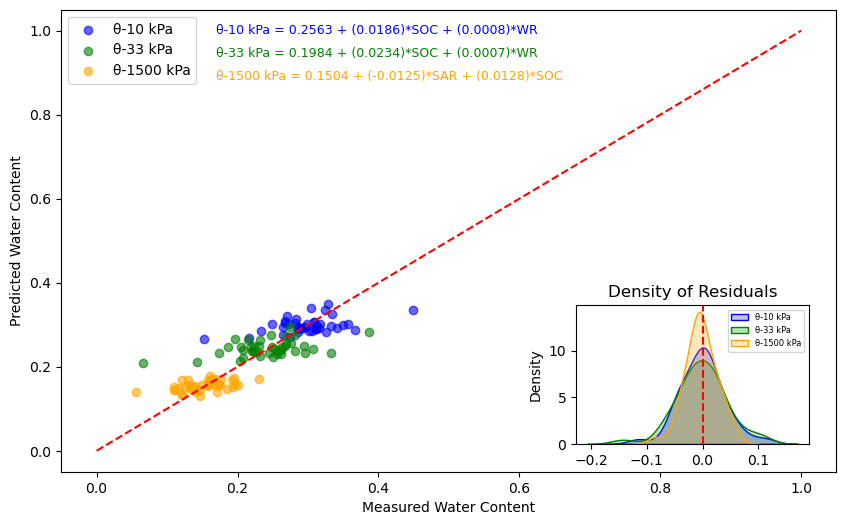

In [13]:
# Prediction using the model
df['Predicted_FC'] = model_fc.predict(df[['SOC', 'WR']])
df['Predicted_FC_33'] = model_fc_33.predict(df[['SOC', 'WR']])
df['Predicted_PWP'] = model_pwp.predict(df[['SAR', 'SOC']])

# Calculate residuals
residuals_fc = df['FC'] - df['Predicted_FC']
residuals_fc_33 = df['FC_33'] - df['Predicted_FC_33']
residuals_pwp = df['PWP'] - df['Predicted_PWP']

# Main scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['FC'], df['Predicted_FC'], label='θ-10 kPa', color='blue', alpha=0.6)
ax.scatter(df['FC_33'], df['Predicted_FC_33'], label='θ-33 kPa', color='green', alpha=0.6)
ax.scatter(df['PWP'], df['Predicted_PWP'], label='θ-1500 kPa', color='orange', alpha=0.6)
ax.plot([0, 1], [0, 1], 'r--')  # Ideal prediction line
fc_formula = f"θ-10 kPa = {model_fc.intercept_:.4f} + " + " + ".join([f"({coef:.4f})*{feat}" for coef, feat in zip(model_fc.coef_, X_fc.columns)])
fc_33_formula = f"θ-33 kPa = {model_fc_33.intercept_:.4f} + " + " + ".join([f"({coef:.4f})*{feat}" for coef, feat in zip(model_fc_33.coef_, X_fc_33.columns)])
pwp_formula = f"θ-1500 kPa = {model_pwp.intercept_:.4f} + " + " + ".join([f"({coef:.4f})*{feat}" for coef, feat in zip(model_pwp.coef_, X_pwp.columns)])
ax.text(0.2, 0.97, fc_formula, fontsize=9, verticalalignment='top', color='blue', transform=plt.gca().transAxes)
ax.text(0.2, 0.92, fc_33_formula, fontsize=9, verticalalignment='top', color='green', transform=plt.gca().transAxes)
ax.text(0.2, 0.87, pwp_formula, fontsize=9, verticalalignment='top', color='orange', transform=plt.gca().transAxes)

# Configuration of axes and plot
ax.set_xlabel('Measured Water Content')
ax.set_ylabel('Predicted Water Content')

ax.legend(loc='upper left')

# Insert for combined density plot
ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=2)
sns.kdeplot(residuals_fc, ax=ax_inset, fill=True, color='blue', label='θ-10 kPa')
sns.kdeplot(residuals_fc_33, ax=ax_inset, fill=True, color='green', label='θ-33 kPa')
sns.kdeplot(residuals_pwp, ax=ax_inset, fill=True, color='orange', label='θ-1500 kPa')
# Set the title for the inset plot
ax_inset.set_title('Density of Residuals')

# Add the reference line at 0
ax_inset.axvline(0, color='red', linestyle='--')

# Configure the legend with a smaller font size
ax_inset.legend(fontsize=6, loc='upper right', frameon=True)

# Show the plot
plt.savefig('pedo_all')
plt.show()


## Evaluate the exsiting PTFs related to SAR

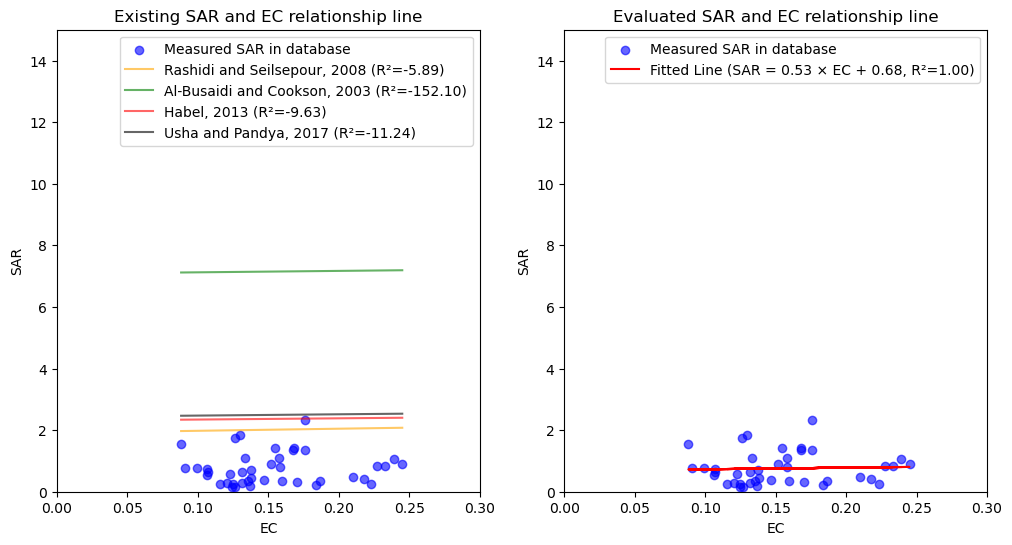

In [14]:
# Calculate predicted SAR values based on different equations
df['sar_Rashidi2008'] = 0.68 * df['EC'] + 1.91
df['sar_AlBusaidi2003'] = 0.464 * df['EC'] + 7.077
df['sar_Usha2017'] = 0.422623 * df['EC'] + 2.429672
df['sar_Habel2013'] = 2.303 + 0.4023 * df['EC']
df['sar_Sarani2015'] = 1.19 * df['EC'] + 0.69 * df['pH'] - 5.02
df['sar_Robbins1993'] = (df['pH'] - 5.86) * (1 + 0.052 * df['EC']) / 0.63 ** 2
df['sar_RobbinsMeyer1990'] = (df['pH'] - 5.86) * (1 + 0.052 * df['EC']) / 0.63 ** 2

# Fit a straight line to the data
slope, intercept = np.polyfit(df['EC'], df['SAR'], 1)
fit_line = slope * df['EC'] + intercept

# Calculate R² values for each regression equation
r2 = r2_score(df['SAR'], df['SAR'])
r2_Rashidi2008 = r2_score(df['SAR'], df['sar_Rashidi2008'])
r2_AlBusaidi2003 = r2_score(df['SAR'], df['sar_AlBusaidi2003'])
r2_Usha2017 = r2_score(df['SAR'], df['sar_Usha2017'])
r2_Habel2013 = r2_score(df['SAR'], df['sar_Habel2013'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Plot different regression lines (left side)
ec_values = np.linspace(df['EC'].min(), df['EC'].max(), 100)
ax1.scatter(df['EC'], df['SAR'], color='blue', alpha=0.6, label=f'Measured SAR in database')
ax1.plot(ec_values, 0.68 * ec_values + 1.91, color='orange', alpha=0.6, label=f'Rashidi and Seilsepour, 2008 (R²={r2_Rashidi2008:.2f})')
ax1.plot(ec_values, 0.464 * ec_values + 7.077, color='green', alpha=0.6, label=f'Al-Busaidi and Cookson, 2003 (R²={r2_AlBusaidi2003:.2f})')
ax1.plot(ec_values, 2.303 + 0.4023 * ec_values, color='red', alpha=0.6, label=f'Habel, 2013 (R²={r2_Habel2013:.2f})')
ax1.plot(ec_values, 0.422623 * ec_values + 2.429672, color='black', alpha=0.6, label=f'Usha and Pandya, 2017 (R²={r2_Usha2017:.2f})')

ax1.set_xlim(0, 0.3)
ax1.set_ylim(0, 15)
ax1.set_xlabel('EC')
ax1.set_ylabel('SAR')
ax1.set_title('Existing SAR and EC relationship line')
ax1.legend()
ax1.grid(False)

# Subplot 2: Plot actual data points and fitted line (right side)
ax2.scatter(df['EC'], df['SAR'], color='blue', alpha=0.6, label=f'Measured SAR in database')
ax2.set_xlim(0, 0.3)

ax2.plot(df['EC'], fit_line, color='red', 
         label=f'Fitted Line (SAR = {slope:.2f} × EC {"+" if intercept >= 0 else "-"} {abs(intercept):.2f}, R²={r2:.2f})')

ax2.set_ylim(0, 15)
ax2.set_xlabel('EC')
ax2.set_ylabel('SAR')
ax2.set_title('Evaluated SAR and EC relationship line')
ax2.legend()
ax2.grid(False)

# Save the plot
plt.savefig("EC_SAR.png")

# Show the plot
plt.show()
